# Clustering using Quadtree

In [1]:
import time
import sys

from point import Point, ClusterPoint
from square import Square
from node import Node

from db_scan import *
from dataset import *
from range_query import RangeQuery

Below is the implementation of QuadTree to cluster the data points.

In [2]:
def QuadBuild(P, S):
    u = Node(None, len(P), S, [])
    if len(P) == 1:
        u.set_point(P[0])
    if len(P) > 1:
        sub_squares = S.splice_square()
        for square in sub_squares:
            v = QuadBuild([point for point in P if square.contains_point(point)], square)
            v.parent = u
            u.add_child(v)
    return u

In [3]:
class QuadTree(RangeQuery):
    """
    Implementation of RangeQuery using a QuadTree
    """

    def __init__(self, points):
        self.points = points
        square = Square.get_bounding_square(points)
        root_node = QuadBuild(points, square) 
        self.root_node = root_node

In [4]:
class QuadTree(QuadTree):
    def report_range(self, p, epsilon):
        """
        Returns the points that lie within range epsilon from p
        """

        neighbors = [] 
        Q = [self.root_node]
        
        while len(Q) != 0:
            u = Q.pop()
            
            if u.point is not None:
                if u.point.sq_distance_to(p) <= (epsilon**u.point.dimension):
                    neighbors.append(u.point)

            for v in u.children:
                if v.square.overlaps_with_circle(center=p, radius=epsilon):
                    Q.append(v)

        return neighbors

In [5]:
class QuadTree(QuadTree):
    def count_range(self, p, epsilon):
        """
        Returns the number of points that lie within range epsilon from p
        """

        count = 0
        Q = [self.root_node]
        
        while len(Q) > 0:
            u = Q.pop()

            if u.point is not None:
                if u.point.sq_distance_to(p) <= (epsilon**u.point.dimension):
                    count += 1
                    
            for v in u.children:
                if v.square.is_contained_in_circle(center=p, radius=epsilon):
                    count += v.size

                elif v.square.overlaps_with_circle(center=p, radius=epsilon):
                    Q.append(v)

        return count

In [6]:
class QuadTree(QuadTree):
    def delete_point(self, point):
        """
        Deletes point from this quad tree
        """

        u = self.root_node
        while len(u.children) > 0:
            for v in u.children:
                if v.square.contains_point(point):
                    u = v
        
        if u.point == point:
            u.point = None
            if u.parent is None:
                u.size = 0
                return u
            
            if u.parent.size == 2:
                for child in u.parent.children:
                    if child != u and child.size == 1:
                        q = child
                        
                while u.parent is not None and u.parent.size == 2:
                    u = u.parent
                    
                u.children = []
                u.point = q.point
                
            while u is not None:
                u.size = u.size - 1
                u = u.parent

## Experiment with different datasets

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets

In [8]:
init_times = []
total_times = []

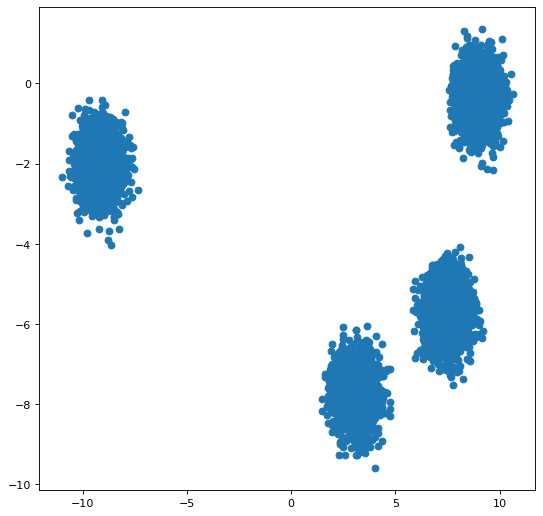

In [9]:
from sklearn.datasets import make_blobs

n_samples = 10000

X, y = make_blobs(n_samples=n_samples, 
                  n_features=2, 
                  centers=4,
                  cluster_std=0.5,
                  random_state=1000)

fig=plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X[:, 0], X[:, 1]);

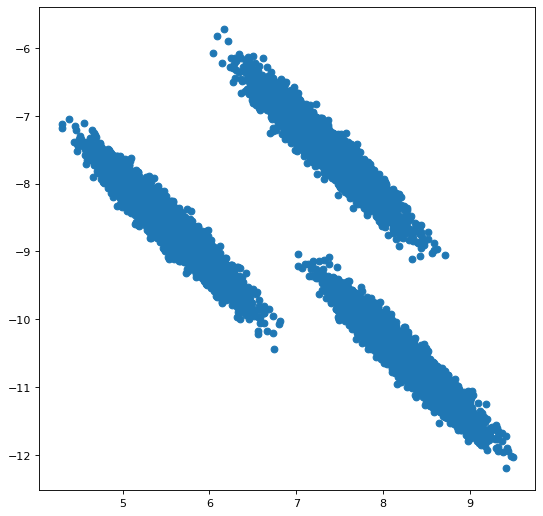

In [10]:
n_samples = 20000

X, y = make_blobs(n_samples=n_samples, 
                  n_features=2, 
                  centers=3,
                  cluster_std=0.4,
                  random_state=1000)
transformation = [[0.8, -0.8], [-0.4, 0.8]]
X = np.dot(X, transformation)
aniso = (X, y)

fig=plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X[:, 0], X[:, 1]);

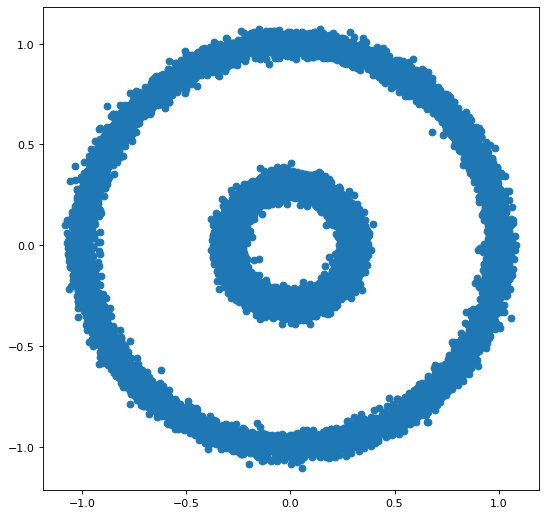

In [11]:
from sklearn.datasets import make_circles

n_samples = 20000

X, y = make_circles(n_samples=n_samples, 
                    factor=0.3,
                    noise=0.03,
                    random_state=1000)

fig=plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X[:, 0], X[:, 1]);

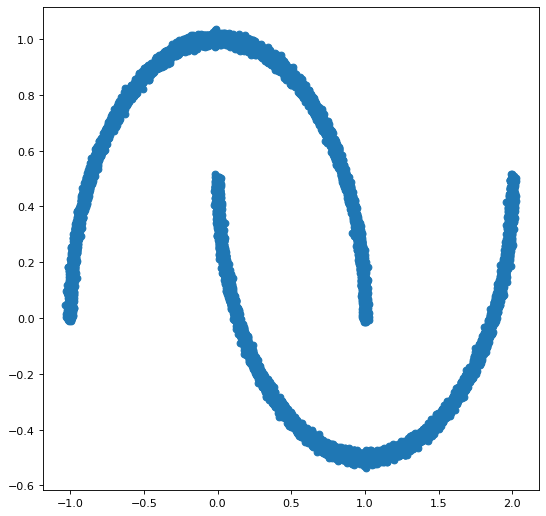

In [12]:
from sklearn.datasets import make_moons

n_samples = 20000

X, y = make_moons(n_samples=n_samples,
                  noise=0.01,
                  random_state=1000)

fig=plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X[:, 0], X[:, 1]);

In [13]:
start = time.time()

coords = X.tolist()
points = [ClusterPoint(2, coord) for coord in coords]

ds = Dataset(n=n_samples, d=2, epsilon=0.4, min_pts=4, points=points)

# Initialize the quad tree
query_obj = QuadTree(ds.cluster_points)

init = time.time()

# Use the quad tree to create a clustering
nr_clusters = find_clustering(ds.cluster_points, ds.epsilon, ds.min_pts, query_obj)

end = time.time()

In [14]:
init_time = init - start
total_time = end - start
print(init_time, total_time)

0.7944440841674805 76.30928587913513


In [15]:
init_times.append(init_time)
total_times.append(total_time)

In [16]:
init_times

[0.7944440841674805]

In [17]:
total_times

[76.30928587913513]

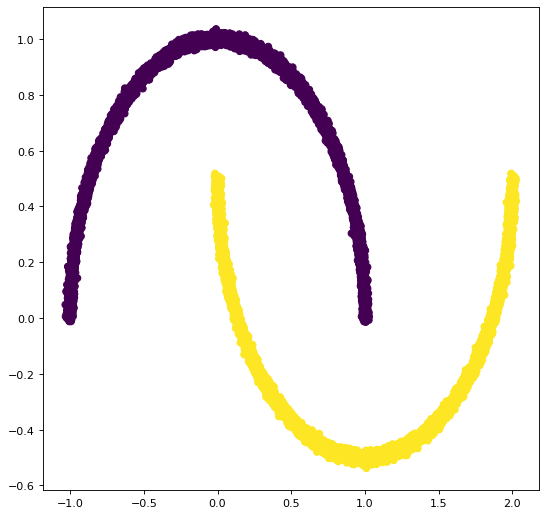

In [18]:
label = [point.cluster_label for point in ds.cluster_points]
fig=plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X[:, 0], X[:, 1], c=label);
#plt.savefig('moon_cluster.png');